In [1]:
from particles import mcmc
from particles import core
import numpy as np
from particles import state_space_models as ssms
from particles import smc_samplers as ssp
import particles
from random import uniform
from particles.mcmc import CSMC
import pandas as pd

KeyboardInterrupt: 

## Particle Gibbs class

In [ ]:
from numba import njit
bs = ssms.Bootstrap

class ParticleGibbsRolling(mcmc.GenericGibbs):
    """Particle Gibbs sampler (abstract class).

    Parameters
    ----------
    niter: int (default=10)
        number of MCMC iterations
    verbose: int (default=0)
        progress report printed every (niter/verbose) iterations (never if 0)
    ssm_cls: `StateSpaceModel` subclass
        parametric class of state-space models
    prior: `StructDist` object
        prior distribution
    data: list-like
        data
    theta0: structured array
        starting point of the chain (if None, generated from the prior)
    Nx: int
        number of x-particles (in the CSMC step)
    fk_cls: FeynmanKac class (default=None)
        which Feynman-Kac model to use (if None, set to ssms.Bootstrap, however,
        one may use instead e.g. ssm.GuidedPF)
    regenerate_data: bool (default=False)
        re-generate the data at each step; in the case the algorithm samples
        from the *prior*; useful to check if the algorithm is correct (i.e.
        if the update_theta method leaves invariant the conditional
        distributions of theta given x and y)
    backward_step: 
    (default=False)
        whether to run the backward step
    store_x: bool (default=False)
        store the states at each iteration (if False only the theta's are
        stored)

    Note
    ----
    To subclass `ParticleGibbs`, define method `update_theta`, which samples
    theta given a state trajectory x.

    """

    def __init__(
        self,
        niter=10,
        verbose=0,
        ssm_cls=None,
        prior=None,
        data=None,
        theta0=None,
        Nx=20,
        fk_cls=None,
        regenerate_data=False,
        backward_step=False,
        store_x=False,
        M=30,
        K=5,
        L=5
    ):
        mcmc.GenericGibbs.__init__(
            self,
            niter=niter,
            verbose=verbose,
            ssm_cls=ssm_cls,
            prior=prior,
            data=data,
            theta0=theta0,
            store_x=store_x,
        )
        self.Nx = Nx
        self.fk_cls = ssms.Bootstrap if fk_cls is None else fk_cls
        self.regenerate_data = regenerate_data
        self.backward_step = backward_step
        self.M = M
        self.K = K
        self.L = L

    def print_verbose(self, message):
        """Prints a message only if verbose mode is enabled."""
        if self.verbose:
            print(message)

    def fk_mod(self, theta):
        ssm = self.ssm_cls(**ssp.rec_to_dict(theta))
        return self.fk_cls(ssm=ssm, data=self.data)

    def update_states(self, theta, x):

        fk = self.fk_mod(theta)
        if x is None:
            cpf = particles.SMC(fk=fk, N=self.Nx, store_history=True)
        else:
            cpf = CSMC(fk=fk, N=self.Nx, xstar=x)

        # Warmup
        w = 0
        while w < self.K + self.L:
            next(cpf)
            w+=1

        print("Warmup done")
        self.cpf = cpf

        new_x = []
        theta['sigma'] = 0.2
        theta['rho'] = 0.95

        for t in range(self.data.shape[0] - self.K - self.L):
            if cpf.fk.done(cpf):
                raise StopIteration
            else:
                # Apply resample_forward for each particle
                # X_history = np.zeros((t+1, self.Nx))  # Array to store history of states

                x_ts = []
                x_ss = []
                x_s1s = []

                for n in range(self.Nx):
                    
                    X_n = np.array(cpf.hist.X)[:, n]
                    
                    x_n, cpf = self.resample_forward(cpf, X_n, theta)
                    x_s, x_s1, cpf = self.resample_backward(cpf, X_n, theta)
                    
                    x_ts.append(x_n)
                    x_ss.append(x_s)
                    x_s1s.append(x_s1)

                print(f"Now at step t: {cpf.t}")
                cpf.Xp = cpf.X
                cpf.X = x_ts
                
                cpf = self.reweight_forward(cpf, x_ts)
                cpf = self.reweight_backward(cpf, x_ss, x_s1s)
                
#                 cpf.reweight_particles()
                cpf.compute_summaries()
                cpf.t += 1
                self.cpf = cpf

        new_x = cpf.hist.backward_sampling_ON2(1)

        return new_x

    def resample_forward(self, cpf, X, theta_n):
        y = cpf.fk.data  # Observations
        k_values = self.sample_k_values()

        # Initialize the lineage array for self.M lineages
        X_tK_t1 = np.zeros((self.K + 1, self.M))

        # Step 2: Set initial state for all lineages to X[-1]
        X_tK_t1[0, :] = X[-1]

        t = cpf.t
        K = self.K

        # Step 3: Propagate particles for each time step j
        for j in range(self.K):  # Loop from t-K+1 to t-1
            v_values_j = self.compute_v_values(X, y, theta_n, t-K+j)
            ancestor_indices = self.sample_ancestor_indices(v_values_j)

            for m in range(self.M):
                # Skip if m is the sampled k value for this j
                if m != k_values[j-1]:
                    # Propagate using the q_function
                    X_tK_t1[j, m] = self.q_function(cpf.t - self.K + j, X_tK_t1[j - 1, ancestor_indices[m]], y[j], cpf, iterations=5)

        # Step 4: Final Sampling for time t
        v_values_t = self.compute_v_values(X, y, theta_n, self.K)
        ancestor_indices_t = self.sample_ancestor_indices(v_values_t)

        # Propagate each lineage for time t
        for m in range(self.M):
            X_tK_t1[self.K, m] = self.q_function(cpf.t, X_tK_t1[self.K - 1, ancestor_indices_t[m]], y[cpf.t], cpf, iterations=10)

        # Print final lineages
        self.print_verbose(f"Selected lineages: {X_tK_t1}")

        # Sample k^*_t and determine the final lineage
        k_star_t = self.sample_ancestor_indices(v_values_t)[0]  # Sampling k^*_t

        # Select the x_t value from the lineage starting at k_star_t
        selected_x_t = X_tK_t1[-1, k_star_t]

        return selected_x_t, cpf

    def sample_k_values(self):
        # Sample K values from {1, ..., M}
        return [int(uniform(1, self.M + 1)) for _ in range(self.K)]

#     def q_function(self, t, xp, yt, cpf, iterations=5):
#         # Initialize x_t based on time step
#         x_t = cpf.fk.M0(1)[0] if t == 0 else cpf.fk.M(t, np.array([xp]))[0]

#         # Iteratively update x_t using Metropolis-Hastings
#         for _ in range(iterations):
#             x_t_proposed = cpf.fk.M(t, np.array([xp]))[0]

#             # Calculate acceptance ratio using log probabilities
#             dist_proposed = self.ssm_cls.PY(self.ssm_cls, t, xp, x_t_proposed)
#             dist_current = self.ssm_cls.PY(self.ssm_cls, t, xp, x_t)
#             log_prob_proposed = dist_proposed.logpdf(yt)
#             log_prob_current = dist_current.logpdf(yt)
#             acceptance_ratio = np.exp(log_prob_proposed - log_prob_current)

#             self.print_verbose(f"Proposed x_t: {x_t_proposed}, Current x_t: {x_t}, Acceptance Ratio: {acceptance_ratio}")

#             # Accept or reject the proposal
#             if np.random.rand() < acceptance_ratio:
#                 x_t = x_t_proposed

#         return x_t

    def set_and_sample_particles(self, cpf, x_n, k_values, M, q_function, theta_n, y_values):
        # Initialize particle states and ancestor indices
        x_particles = [None] * M
        a_particles = [None] * M

        # print("Debugging Information:")
        # print("x_n:", x_n)
        # print("Length of x_n:", len(x_n))
        # print("k_values:", k_values)
        # print("Length of k_values:", len(k_values))
        # print("x_particles:", x_particles)
        # print("Length of x_particles:", len(x_particles))

        # Set particle states and ancestor indices
        for i, k in enumerate(k_values):

            # print(f"Current index i: {i}, Current k value: {k}, Adjusted index (k - 1): {k - 1}")

            x_particles[k - 1] = x_n[i]
            if i < len(k_values) - 1:
                a_particles[k_values[i + 1] - 1] = k

        # Sample for other particles
        for m in range(1, M + 1):
            if m not in k_values:
                x_particles[m - 1] = x_n[-1]  # Set to the last element in x_n
                x_particles[m - 1] = self.q_function(cpf.t-self.K, x_n[-1], y_values[-1], cpf)

        return x_particles, a_particles

    def f(self, theta_n, x_j, x_j_1):
        """State transition probability."""
        dist = self.ssm_cls.PX(theta_n, x_j_1)
        return np.exp(dist.logpdf(x_j))

    def g(self, theta_n, y_j, x_j):
        """Observation likelihood."""
        dist = self.ssm_cls.PY(self.ssm_cls, theta_n, None, x_j)
        return np.exp(dist.logpdf(y_j))

    def compute_v_values(self, X, y, theta_n, j):
        v_values = np.zeros(self.M)
        g_values = np.zeros(self.M)

        # Calculate g values for all lineages
        for m in range(self.M):
            x_jm = X[j]  # State of the lineage at time j
            g_values[m] = self.g(theta_n, y[j], x_jm)

        # Compute v values
        g_sum = np.sum(g_values)
        for m in range(self.M):
            v_values[m] = g_values[m] / g_sum if g_sum != 0 else 1 / self.M

        return v_values

    def q_function(self, t, xp, yt, cpf, iterations=5):
        x_t = cpf.fk.M0(1)[0] if t == 0 else cpf.fk.M(t, np.array([xp]))[0]
        for _ in range(iterations):
            x_t_proposed = cpf.fk.M(t, np.array([xp]))[0]
            dist_proposed = self.ssm_cls.PY(self.ssm_cls, t, xp, x_t_proposed)
            dist_current = self.ssm_cls.PY(self.ssm_cls, t, xp, x_t)
            acceptance_ratio = np.exp(dist_proposed.logpdf(yt) - dist_current.logpdf(yt))
            if np.random.rand() < acceptance_ratio:
                x_t = x_t_proposed
        return x_t

    def sample_ancestor_indices(self, v_values):
        """
        Sample ancestor indices from the categorical distribution defined by v_values.

        :param v_values: Computed v values representing probabilities for each ancestor index.
        :return: An array of sampled ancestor indices.
        """
        ancestor_indices = np.random.choice(self.M, size=self.M, p=v_values)
        self.print_verbose(f"Sampled Ancestor Indices: {ancestor_indices}")
        return ancestor_indices

    def resample_backward(self, cpf, X, theta_n):
        y = cpf.fk.data  # Observations
        s = cpf.t - self.L  # Starting time
        t = cpf.t  # Ending time
        k_values = self.sample_k_values()

        # Initialize the lineage array for self.M lineages
        X_sL_s = np.zeros((self.L + 1, self.M))

        # Step 2: Set initial state for all lineages to X[s]
        X_sL_s[0, :] = X[s]

        # Step 3: Propagate particles for each time step j in reverse
        for j in range(self.L-1, 0, -1):  # Loop from t-1 to s
            v_values_j = self.compute_v_values(X, y, theta_n, s + j)
            ancestor_indices = self.sample_ancestor_indices(v_values_j)

            for m in range(self.M):
                # Skip if m is the sampled k value for this j
                if m != k_values[j]:
                    # Propagate using the q_function
                    X_sL_s[self.L - j, m] = self.q_function(s + j - 1, X_sL_s[self.L - j + 1, ancestor_indices[m]], y[s + j - 1], cpf, iterations=10)

        # Step 4: Final Sampling for time s
        v_values_s = self.compute_v_values(X, y, theta_n, s)
        ancestor_indices_s = self.sample_ancestor_indices(v_values_s)

        # Propagate each lineage for time s
        for m in range(self.M):
            X_sL_s[self.L, m] = self.q_function(s, X_sL_s[self.L - 1, ancestor_indices_s[m]], y[s], cpf, iterations=10)

        # Print final lineages
#         cpf.print_verbose(f"Selected lineages: {X_sL_s}")

        # Sample k^*_s and determine the final lineage
        k_star_s = self.sample_ancestor_indices(v_values_s)[0]  # Sampling k^*_s

        # Select the x_s value from the lineage starting at k_star_s
        selected_x_s = X_sL_s[-1, k_star_s]
        selected_x_s1 = X_sL_s[-2, k_star_s]
        
        return selected_x_s, selected_x_s1, cpf
    
    def reweight_forward(self, cpf, x_t):
        cpf.wgts = cpf.wgts.add(cpf.fk.logG(cpf.t, cpf.Xp, x_t))
        return cpf
    
    def reweight_backward(self, cpf, x_s, x_s1):
        cpf.wgts = cpf.wgts.add(-cpf.fk.logG(cpf.t, x_s1, x_s))
        return cpf
    

In [ ]:
class PGStochVol(ParticleGibbsRolling):

    def update_theta(self, theta, x):
        new_theta = theta.copy()
        sigma, rho = 0.2, 0.95  # fixed values
        xlag = np.array(x[1:] + [0.,])
        dx = (x - rho * xlag) / (1. - rho)
        s = sigma / (1. - rho)**2
        new_theta['mu'] = self.prior.laws['mu'].posterior(dx, sigma=s).rvs()
        new_theta['sigma'] = sigma
        new_theta['rho'] = rho
        return new_theta

In [ ]:
from particles import state_space_models as ssm

class StochVol(ssm.StateSpaceModel):
    default_parameters = {'mu':-1., 'rho':0.95, 'sigma': 0.2}

    def __init__(self, mu=None, rho=None, sigma=None):
        
        self.mu = -1. if mu is None else mu
        self.rho = .95 if rho is None else rho
        self.sigma = .2 if sigma is None else sigma
        
    def PX0(self):  # Distribution of X_0
        return dists.Normal(loc=self.mu, scale=self.sigma / np.sqrt(1. - self.rho**2))
    def PX(self, t, xp):  # Distribution of X_t given X_{t-1}=xp (p=past)
        return dists.Normal(loc=self.mu + self.rho * (xp - self.mu), scale=self.sigma)
    def PY(self, t, xp, x):  # Distribution of Y_t given X_t=x (and possibly X_{t-1}=xp)
        return dists.Normal(loc=0., scale=np.exp(x))

In [ ]:
from particles import distributions as dists
from particles import datasets as dts  # real datasets available in the package

prior_dict = {'mu': dists.Normal(scale=2.),
              'rho': dists.Uniform(a=-1., b=1.),
              'sigma':dists.Gamma()}

my_prior = dists.StructDist(prior_dict)

In [ ]:
dts.GBP_vs_USD_9798().data.shape

In [ ]:
T = 100
data = dts.GBP_vs_USD_9798().data[:T]

In [ ]:
pd.DataFrame(list(map(lambda x: x.W, pg.cpf.hist.wgts))).apply(lambda x: 1/np.sum(np.square(x)), axis=1).plot()

In [ ]:
pg = PGStochVol(ssm_cls=StochVol, data=data, prior=my_prior, Nx=30, niter=10, verbose=0, store_x=False)

In [ ]:
pg.run()

In [ ]:
list(pg.chain.theta[-1])

In [ ]:
args = dict(zip(list(prior_dict.keys()), list(pg.chain.theta[-1])))

In [ ]:
sv_class = StochVol(**args)

In [ ]:
x, y = sv_class.simulate(200)

In [ ]:
pd.DataFrame(pg.chain.theta).mean().plot()

In [ ]:
pd.DataFrame(data).plot(figsize=(20, 5))

In [ ]:
pd.DataFrame(y).applymap(float).plot(figsize=(20, 5))

## RSV Model 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns

import scienceplots
plt.style.use(['science', 'notebook'])

y = pd.read_pickle('y.pck').to_numpy()

from scipy.stats import invwishart
import numba

class InvWishart(dists.ProbDist):
    """Inverse Gamma(a,b) distribution."""

    def __init__(self, r=1.0, S=1.0):
        self.r = r
        self.S = S

    def rvs(self, size=None):
        return invwishart.rvs(self.r, self.S, size=size)

    def logpdf(self, x):
        x = np.dot(x.reshape(2, 2).T, x.reshape(2, 2))
        return invwishart.logpdf(x, self.r, scale=self.S)


class RSVModel(ssm.StateSpaceModel):
        
    def extract_params(self):
        
        
        self.Sig = (self.Sig+self.Sig.T)/2
        self.phi = 2*self.omega - 1
        self.sig_eps = np.sqrt(abs(self.Sig[0, 0]))
        self.mu = 2*np.log(self.sig_eps)
        self.xi = self.c - self.mu
        self.sig_eta = np.sqrt(abs(self.Sig[1, 1]))
        self.rho = self.Sig[1, 0]/(self.sig_eps*self.sig_eta)
                

    def PX0(self):  
        self.extract_params()
        return dists.Normal(loc=self.mu, scale=self.sig_eta*(1-self.phi**2)**(-.5))  # X_0 ~ N(0, 1)
    
    def PX(self, t, xp):  # Distribution of X_t given X_{t-1}
        self.extract_params() 
        return dists.Normal(loc=self.mu + self.phi*(xp-self.mu), scale=self.sig_eta)  # X_t ~ N( X_{t-1}, 1)
    
    def PY(self, t, xp, x):
        
        self.extract_params()
        N = len(x)
        cov_ = np.zeros((N, 2, 2))
        sig_u_squared = self.sig_u**2

        loc_ = np.vstack([np.zeros_like(x), x + self.xi]).T   

        self.build_cov_matrix(cov_, x, sig_u_squared)

        cov_ = np.nan_to_num(cov_, copy=True, nan=1.0)
        loc_ = np.nan_to_num(loc_, copy=True, nan=1.0)
        
        return dists.VaryingCovNormal(loc=loc_, cov=cov_)

    @staticmethod
    @numba.jit(nopython=True, parallel=True)
    def build_cov_matrix(cov_, x, sig_u_squared):
        N = len(x)
        for n in numba.prange(N):
            cov_[n, :, :] = np.array([[np.exp(float(x[n])/2), 0], [0, sig_u_squared]])


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns

import scienceplots
plt.style.use(['science', 'notebook'])

y = pd.read_pickle('y.pck').to_numpy()

from scipy.stats import invwishart
import numba

class InvWishart(dists.ProbDist):
    """Inverse Gamma(a,b) distribution."""

    def __init__(self, r=1.0, S=1.0):
        self.r = r
        self.S = S

    def rvs(self, size=None):
        return invwishart.rvs(self.r, self.S, size=size)

    def logpdf(self, x):
        x = np.dot(x.reshape(2, 2).T, x.reshape(2, 2))
        return invwishart.logpdf(x, self.r, scale=self.S)


class RSVModel(ssm.StateSpaceModel):
        
    def extract_params(self):
        
        
        self.Sig = (self.Sig+self.Sig.T)/2
        self.phi = 2*self.omega - 1
        self.sig_eps = np.sqrt(abs(self.Sig[0, 0]))
        self.mu = 2*np.log(self.sig_eps)
        self.xi = self.c - self.mu
        self.sig_eta = np.sqrt(abs(self.Sig[1, 1]))
        self.rho = self.Sig[1, 0]/(self.sig_eps*self.sig_eta)
                

    def PX0(self):  
        self.extract_params()
        return dists.Normal(loc=self.mu, scale=self.sig_eta*(1-self.phi**2)**(-.5))  # X_0 ~ N(0, 1)
    
    def PX(self, t, xp):  # Distribution of X_t given X_{t-1}
        self.extract_params() 
        return dists.Normal(loc=self.mu + self.phi*(xp-self.mu), scale=self.sig_eta)  # X_t ~ N( X_{t-1}, 1)
    
    def PY(self, t, xp, x):
        
        self.extract_params()
        N = len(x)
        cov_ = np.zeros((N, 2, 2))
        sig_u_squared = self.sig_u**2

        loc_ = np.vstack([np.zeros_like(x), x + self.xi]).T   

        self.build_cov_matrix(cov_, x, sig_u_squared)

        cov_ = np.nan_to_num(cov_, copy=True, nan=1.0)
        loc_ = np.nan_to_num(loc_, copy=True, nan=1.0)
        
        return dists.VaryingCovNormal(loc=loc_, cov=cov_)

    @staticmethod
    @numba.jit(nopython=True, parallel=True)
    def build_cov_matrix(cov_, x, sig_u_squared):
        N = len(x)
        for n in numba.prange(N):
            cov_[n, :, :] = np.array([[np.exp(float(x[n])/2), 0], [0, sig_u_squared]])


In [ ]:
Sig_0 = np.linalg.inv(5*np.array([[1, -.3*.1], [-.3*.1, 1]]))

prior_dict = {'omega':dists.Beta(20, 1.5),
              'c': dists.Normal(0, 10),
              'sig_u':dists.InvGamma(5/2, .05/2),
              'Sig': InvWishart(5, Sig_0)
             }

prior_dict['Sig'].dim = (2, 2)

my_prior = dists.StructDist(prior_dict)

In [ ]:
my_pmmh = mcmc.PMMH(ssm_cls=RSVModel, prior=my_prior, data=y, Nx=100,
                    niter=1000, verbose=0, adaptive=True, smc_options=smc_options)

my_pmmh.run()

In [32]:
pg.chain.theta

array([( 3.53345924e+000, 4.60579078e-001, 2.88992269e+000),
       (-8.35346252e-001, 4.60579078e-001, 2.88992269e+000),
       ( 3.89734401e+000, 4.60579078e-001, 2.88992269e+000),
       ( 4.49723040e-001, 4.60579078e-001, 2.88992269e+000),
       ( 2.78974234e+000, 4.60579078e-001, 2.88992269e+000),
       ( 1.94610572e-001, 4.60579078e-001, 2.88992269e+000),
       ( 1.29611730e+000, 4.60579078e-001, 2.88992269e+000),
       ( 1.44832264e+000, 4.60579078e-001, 2.88992269e+000),
       ( 1.39744697e-001, 4.60579078e-001, 2.88992269e+000),
       ( 1.20790711e+000, 4.60579078e-001, 2.88992269e+000),
       ( 1.27801150e+000, 4.60579078e-001, 2.88992269e+000),
       ( 1.35984350e+000, 4.60579078e-001, 2.88992269e+000),
       (-8.81646730e-001, 4.60579078e-001, 2.88992269e+000),
       ( 7.87611723e-001, 4.60579078e-001, 2.88992269e+000),
       ( 3.28922119e+000, 4.60579078e-001, 2.88992269e+000),
       ( 6.08888542e-013, 1.41740454e+190, 6.01334504e-154),
       ( 6.01347002e-154

<Axes: >

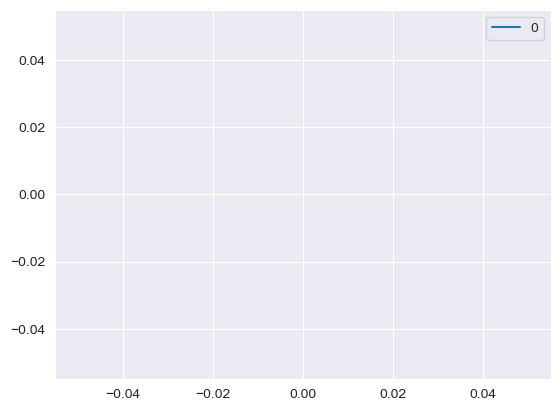

In [34]:
pd.DataFrame(y).applymap(float).plot()

## RSV Model 

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns

import scienceplots
plt.style.use(['science', 'notebook'])

y = pd.read_pickle('y.pck').to_numpy()

from scipy.stats import invwishart
import numba

class InvWishart(dists.ProbDist):
    """Inverse Gamma(a,b) distribution."""

    def __init__(self, r=1.0, S=1.0):
        self.r = r
        self.S = S

    def rvs(self, size=None):
        return invwishart.rvs(self.r, self.S, size=size)

    def logpdf(self, x):
        x = np.dot(x.reshape(2, 2).T, x.reshape(2, 2))
        return invwishart.logpdf(x, self.r, scale=self.S)


class RSVModel(ssm.StateSpaceModel):
        
    def extract_params(self):
        
        
        self.Sig = (self.Sig+self.Sig.T)/2
        self.phi = 2*self.omega - 1
        self.sig_eps = np.sqrt(abs(self.Sig[0, 0]))
        self.mu = 2*np.log(self.sig_eps)
        self.xi = self.c - self.mu
        self.sig_eta = np.sqrt(abs(self.Sig[1, 1]))
        self.rho = self.Sig[1, 0]/(self.sig_eps*self.sig_eta)
                

    def PX0(self):  
        self.extract_params()
        return dists.Normal(loc=self.mu, scale=self.sig_eta*(1-self.phi**2)**(-.5))  # X_0 ~ N(0, 1)
    
    def PX(self, t, xp):  # Distribution of X_t given X_{t-1}
        self.extract_params()
        return dists.Normal(loc=self.mu + self.phi*(xp-self.mu), scale=self.sig_eta)  # X_t ~ N( X_{t-1}, 1)
    
    def PY(self, t, xp, x):
        
        self.extract_params()
        N = len(x)
        cov_ = np.zeros((N, 2, 2))
        sig_u_squared = self.sig_u**2

        loc_ = np.vstack([np.zeros_like(x), x + self.xi]).T   

        self.build_cov_matrix(cov_, x, sig_u_squared)

        cov_ = np.nan_to_num(cov_, copy=True, nan=1.0)
        loc_ = np.nan_to_num(loc_, copy=True, nan=1.0)
        
        return dists.VaryingCovNormal(loc=loc_, cov=cov_)

    @staticmethod
    @numba.jit(nopython=True, parallel=True)
    def build_cov_matrix(cov_, x, sig_u_squared):
        N = len(x)
        for n in numba.prange(N):
            cov_[n, :, :] = np.array([[np.exp(float(x[n])/2), 0], [0, sig_u_squared]])


In [423]:
Sig_0 = np.linalg.inv(5*np.array([[1, -.3*.1], [-.3*.1, 1]]))

prior_dict = {'omega':dists.Beta(20, 1.5),
              'c': dists.Normal(0, 10),
              'sig_u':dists.InvGamma(5/2, .05/2),
              'Sig': InvWishart(5, Sig_0)
             }

prior_dict['Sig'].dim = (2, 2)

my_prior = dists.StructDist(prior_dict)

(10, 50)

In [ ]:
my_pmmh = mcmc.PMMH(ssm_cls=RSVModel, prior=my_prior, data=y, Nx=100,
                    niter=1000, verbose=0, adaptive=True, smc_options=smc_options)

my_pmmh.run()